# Coursework C

 Some of the code from this notebook is heavily inspired by https://machine-learning-for-physicists.org and is relased under the same Creative Commons License.

### Import Libraries

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

from scipy import linalg

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.18.0


## Load the MNIST dataset

The Keras library comes with a number of builtin datasets. One of which is the MNIST library of handwritten digits.

In [36]:
mnist = keras.datasets.mnist   #The original handwritten digit MNIST
#mnist = keras.datasets.fashion_mnist   #A tricky version that uses images of fashion items
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Scale pixel value to between 0 and 1 before training them, otherwise model fit does not work
train_images=train_images/255.0
test_images=test_images/255.0



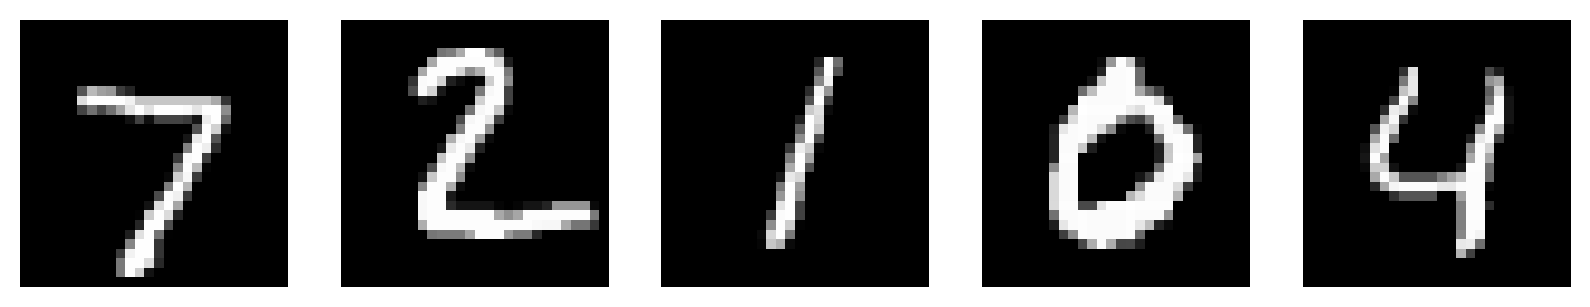

In [37]:
import matplotlib.pyplot as plt

# Assuming 'test_images' contains the test images
# and 'num_images' is the number of images to display

num_images = 5  # You can change this to display more/fewer images

fig, axes = plt.subplots(1, num_images, figsize=(10, 5))  # Adjust figsize as needed

for i in range(num_images):
  axes[i].imshow(test_images[i], cmap='gray')  # Display image in grayscale
  axes[i].axis('off')  # Remove axes ticks and labels

plt.show()

## Building our neural network

Now we will use Keras to build our neural network.

### Set up the layers

A neural network is made up of layers and in the simple case these layers are applied sequentially.

In [38]:
model = keras.Sequential([
    keras.layers.Input(shape=(28,28)),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10)
])

This model has three layers:
1. The first layer simply 'flattens' our 28x28 pixel image into a 1-dimensional array of length 784 (=28x28). (Despite all the fancy features most neural networks are at heart one-dimensional in temrs of input*** of course higher dimensionality can always be squashed down to a larger single dimension). This layer has no paramters.
2. The second layer is fully connected (or *dense*) layer with 128 nodes. This layer has parameters.
3. The third layer is the output layer and has 10 nodes which correspond to the digits 0:9. This layer has parameters.

## From layers to a compiled model

Before we can train the model we need to determine the:
- *Loss function* - This is used to tell us how well our model is doing in
- *Optimiser* - This is how the model gets updated based on the data and the loss function
- *Metrics* - Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [39]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              metrics=['accuracy'])

## Train the model
To train the model we need to show the training data to the model. In our case the training data is the `train_images` and `train_labels` arrays. The model will hopefully *learn* how to associate the images and the labels.

### Fitting the model to the data
The training process is also called fitting the model to the data (for obvious reasons). The Keras syntax for fitting the model uses `model.fit`

In [40]:
model.fit(train_images, train_labels,batch_size=100, epochs=10) # I found that 10 epochs is enough

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8658 - loss: 0.4583
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9638 - loss: 0.1267
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9752 - loss: 0.0835
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9809 - loss: 0.0619
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9856 - loss: 0.0476
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9896 - loss: 0.0351
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9915 - loss: 0.0275
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9932 - loss: 0.0221
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9945 - loss: 0.0182
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9946 - loss: 0.0170


In the above output you can see that the model improves the loss (this number gets smaller) and accuracy (this number gets bigger) with each epoch. But doing well on the training data set is a bit like marking your own homework. A fairer test is to evaluate the performance on the testing data set (which the model has not seen).

In [41]:
# Lets check what the test iamges look like
print(np.shape(test_images))
# model is just the neural network that we trained and it has a function .evaluate
# that executes itself on some test_images and compares its predictions to the
# test_lables to asses its performance. Verbose is just the amount of output
# shown at the bottom
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

(10000, 28, 28)
313/313 - 1s - 2ms/step - accuracy: 0.9773 - loss: 0.0797

Test accuracy: 0.9772999882698059


This is above the 95% test accuracy threshold as required.

Now let's decompose the MNIST dataset into it's PCA components.

Let's consider $N$ data points $\{ x_1,\cdots,x_N \}$ that live in a $p$-dimensional space $\mathbb{R}^p$. First we will zero-mean the data such that $\mu=\frac{1}{N}\sum_i x_i =0$, then we will construct a matrix $X$ whose rows are the data points and columns the dimensions
$$X=\left[x_1,x_2,\cdots, x_N \right]^T$$

Then we can form the covariance matrix $\Sigma(X)$ which is a $p \times p$ symmetric matrix
$$\Sigma(X)=\frac{1}{N-1}X^TX$$
The diagonal elements of this matrix are the variances along each of the $p$-dimensions.


To find the principles we need to find the eigenvectors of the covariance matrix and the corresponding eigenvalues. The first principle component would the eigenvector with the largest associated eigenvalue.

In [42]:
X =np.reshape(train_images,(60000,784)) # The images are 28 x 28 so lets flatten them
print("X.shape:",np.shape(X)) # so our p is 728 and N is 60,000

mu=np.mean(X,axis=0) # We're going to use this later

rho=np.cov(X,rowvar=False) # Calculate the covariance of x, this function does the mean centering and normalisation
print("rho.shape:",np.shape(rho)) # This confirms that the covariance matrix is indeed a p x p matrix

#Get the eigenvalues and vectors
vals,vecs=linalg.eigh(rho)
#vals is a 1-D array of the eigenvalues in ascending order, vecs is a columnwise array of the normalised
# eigenvectors such that vecs[:,i] is the eigenvector correspondong to vals[i]
print("vecs.shape:",np.shape(vecs))
print("vals.shape:",np.shape(vals))
vecs=np.flip(vecs) # These are the principle components.
vals=np.flip(vals) # eigenvalues and eigenvectors are normally given in ascending order, this make it descending. So first column is the first principle component
# The principal components are the directions in the data space along which the data varies the most.
# The first principal component (corresponding to the largest eigenvalue) captures the direction of maximum variance.

X.shape: (60000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


The principal components are the directions in the data space along which the data varies the most. The first principal component (corresponding to the largest eigenvalue) captures the direction of maximum variance.

## Testing our network with N-best PCA component images

We're now going to create some test images using the N-best PCA components and see how well our neural network peforms in identifying them.

We're going to use sets of 10,000 test images with PCA Components `[2, 10, 50, 100, 200, 500, 784]`.

## Using the first $N$ components
To reconstruct our images we use the equation

$$ y = P v^T $$


where
$$ P = X v $$

where $X$ is covariance matrix and v are our eigenvectors.

x.shape: (60000, 784)
P.shape: (60000, 784)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0955 - loss: 7.9021
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0916 - loss: 12.1878
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0897 - loss: 16.1830
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0937 - loss: 16.7575
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0909 - loss: 16.8488
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0924 - loss: 17.0451
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0944 - loss: 17.1273


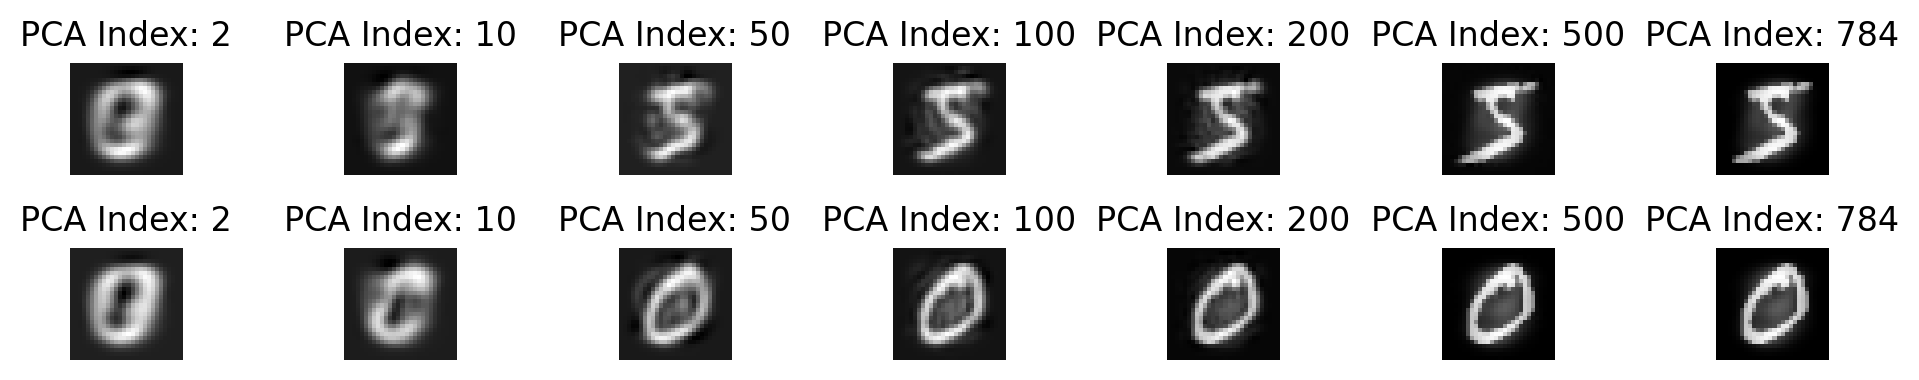

[0.1005 0.0972 0.0963 0.0981 0.0973 0.0976 0.0982]


In [43]:
PCA_Components = np.array([2, 10, 50, 100, 200, 500, 784])
accuracy_array = np.zeros(len(PCA_Components))

P=np.dot(X,vecs)

print("x.shape:",X.shape)
print("P.shape:",P.shape)

numbers = 2

fig, axes = plt.subplots(numbers, len(PCA_Components), figsize=(10, 2))


for i in range(len(PCA_Components)):
    newImages = (np.dot(P[:, 0:PCA_Components[i]], vecs.T[0:PCA_Components[i], :])) + mu
    newImages = np.reshape(newImages[:10000], [10000, 28, 28])
    predictions = model.evaluate(newImages, test_labels)
    accuracy_array[i] = predictions[1]

    for j in range(numbers):
      axes[j, i].imshow(newImages[j], cmap='gray')
      axes[j, i].axis('off')
      axes[j, i].set_title(f'PCA Index: {PCA_Components[i]}')

plt.tight_layout()
plt.show()

plt.show()


We can see that as we reconstruct the images with a higher PCA index, they become more clear and similiar to the original input images, although they do have some noise.

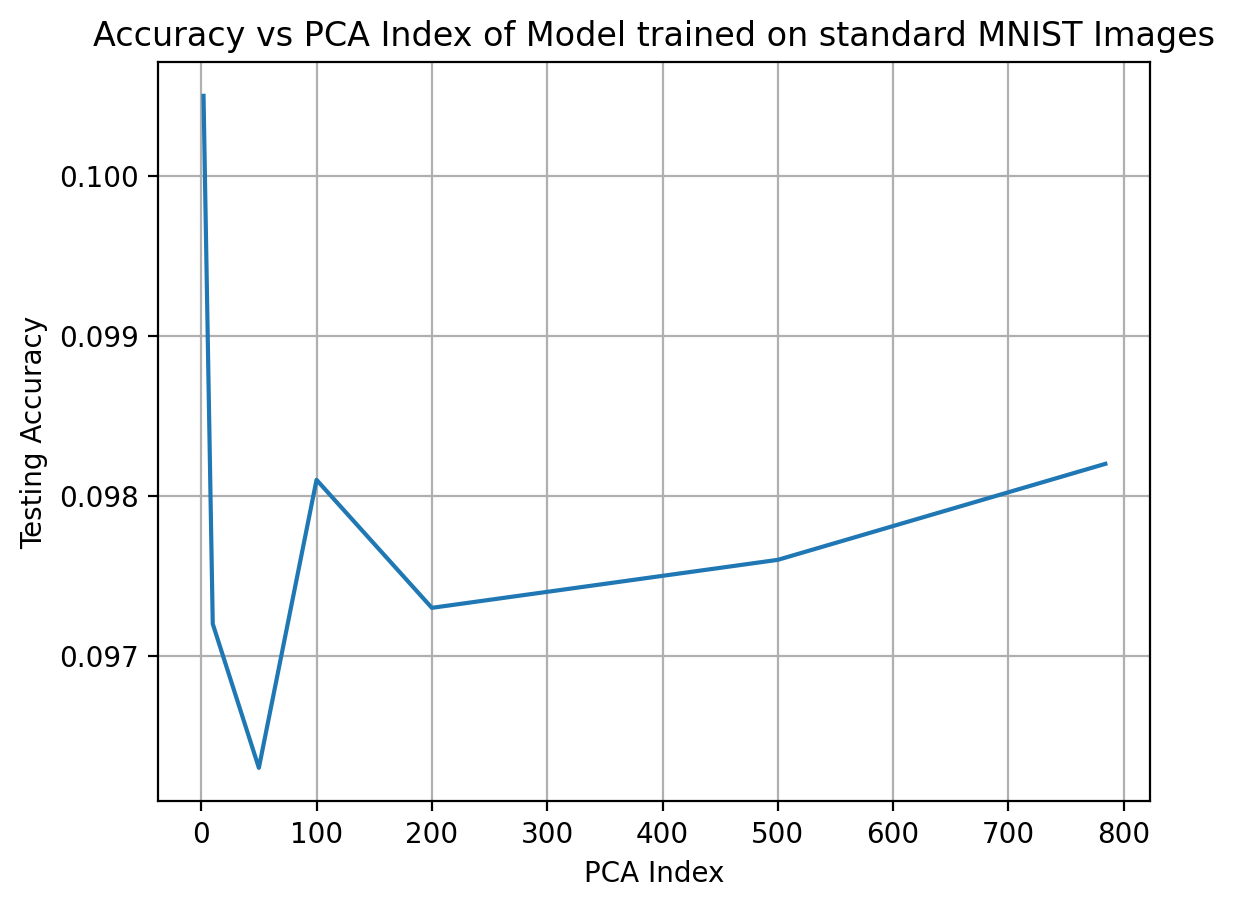

In [44]:
fig,ax=plt.subplots()
ax.plot(PCA_Components,accuracy_array)
ax.set_xlabel("PCA Index")
ax.set_ylabel("Testing Accuracy")
ax.set_title("Accuracy vs PCA Index of Model trained on standard MNIST Images")
ax.grid()

The accuracies are all generally around 0.1 which is the expected accuracy for a model completely guessing the number. It's clear that adding noise completely throws off the model which was solely trained with noise free images.

## Testing a Trained model

Our initial model was untrained on the PCA images but we're going to now train it on 100-best PCA component images.

In [45]:
# Create images with 100 PCA components

newImages100=(np.dot(P[:,0:100],vecs.T[0:100,:]))+mu
newImages100=np.reshape(newImages100,(60000,28,28))

# Train Model
model.fit(newImages100, train_labels,batch_size=100, epochs=25) # I found that 25 epochs is enough

Epoch 1/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9607 - loss: 0.1309
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9797 - loss: 0.0618
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9846 - loss: 0.0477
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9858 - loss: 0.0415
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9872 - loss: 0.0387
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9871 - loss: 0.0378
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9872 - loss: 0.0373
Epoch 8/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9896 - loss: 0.0317
Epoch 9/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9893 - loss: 0.0317
Epoch 10/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9891 - loss: 0.0316
Epoch 11/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9907 - loss: 0.0282
Epoch 12/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

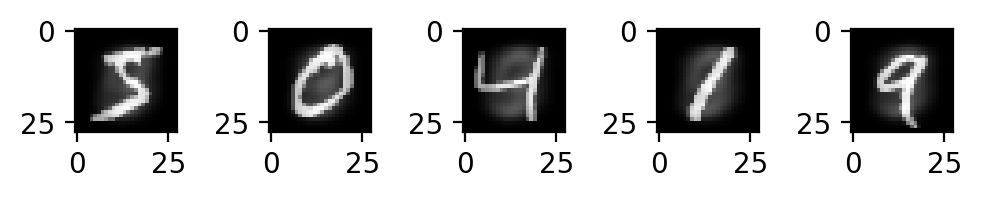

In [60]:
# Let's see what the images look like

NO_Images = 5
fig, axes = plt.subplots(1, NO_Images, figsize=(5, 1))

for i in range(NO_Images):
  axes[i].imshow(newImages100[i], cmap='gray')

plt.tight_layout()
plt.show()

In [46]:
# Lets check to see if the model still performs well on the test images
test_loss, test_acc = model.evaluate(train_images,  train_labels, verbose=2)
print('\nTest accuracy:', test_acc)

1875/1875 - 3s - 2ms/step - accuracy: 0.9680 - loss: 0.1853

Test accuracy: 0.9679999947547913


In [47]:
# Test out how well the trained model works for image with 100 different PCA components
for i in range(len(PCA_Components)):
    newImages100 = (np.dot(P[:, 0:PCA_Components[i]], vecs.T[0:PCA_Components[i], :])) + mu
    newImages100 = np.reshape(newImages100, [60000, 28, 28])
    predictions = model.evaluate(newImages100, train_labels)
    accuracy_array[i] = predictions[1]

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1247 - loss: 7.0686
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5371 - loss: 2.6528
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9641 - loss: 0.1495
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9895 - loss: 0.0325
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9844 - loss: 0.0504
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9832 - loss: 0.0662
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9833 - loss: 0.0677


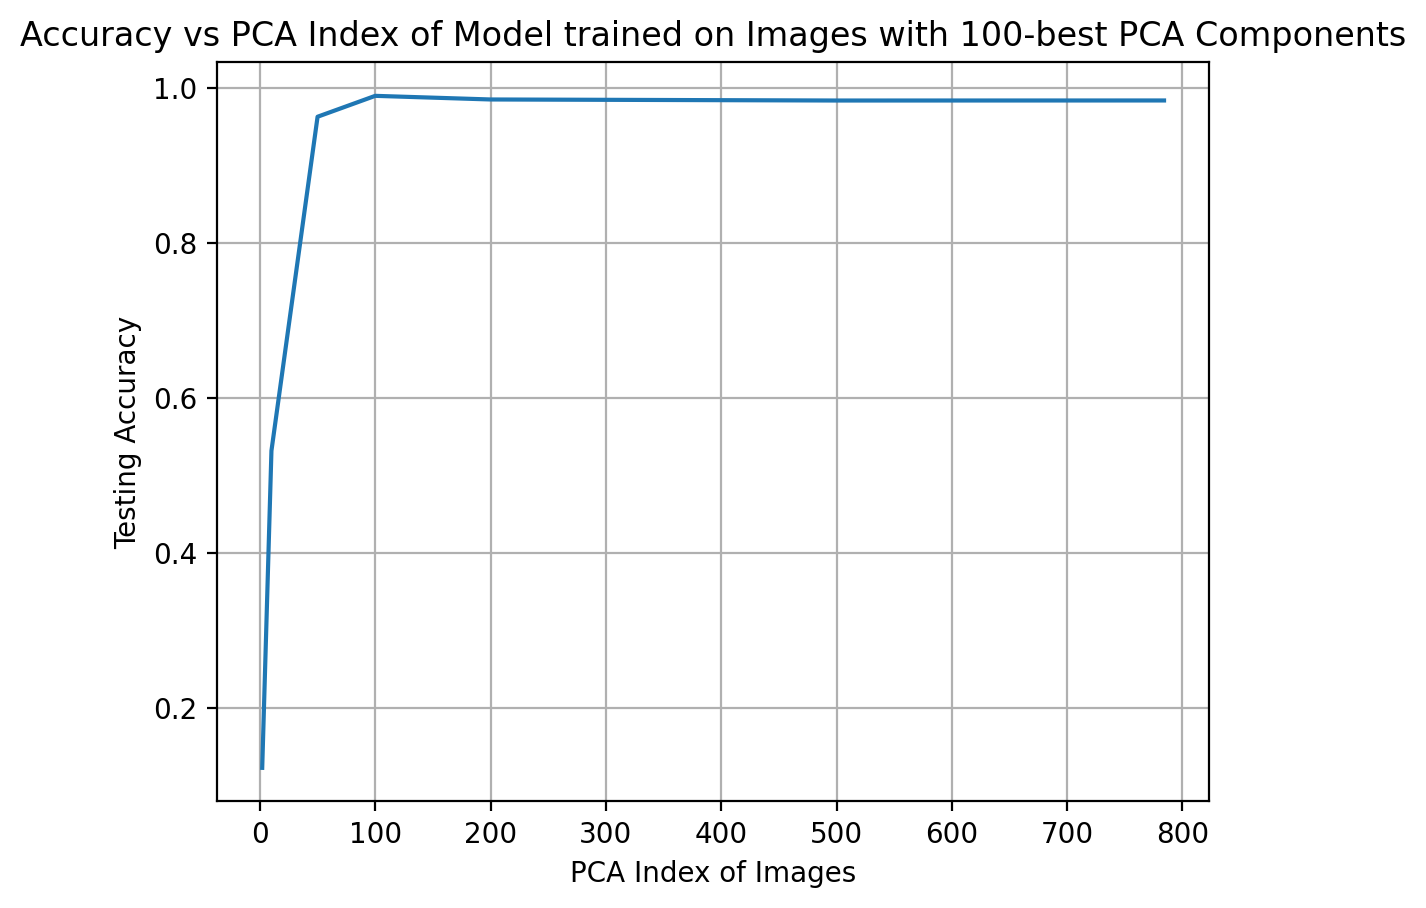

In [48]:
fig,ax=plt.subplots()
ax.plot(PCA_Components,accuracy_array)
ax.set_xlabel("PCA Index of Images")
ax.set_ylabel("Testing Accuracy")
ax.set_title("Accuracy vs PCA Index of Model trained on Images with 100-best PCA Components")
ax.grid()

The model peaks at 100-best PCA components and then slightly drops off before staying constant. This is quite strange as you would assume that the model would be able to predict the images better when they have more PCA-components.

Let's now try training with 20-best PCA component images.

In [62]:
# Create images with 20 PCA components

newImages20=(np.dot(P[:,0:20],vecs.T[0:20,:]))+mu
newImages20=np.reshape(newImages20,(60000,28,28))

# Train Model
model.fit(newImages20, train_labels,batch_size=100, epochs=25)


Epoch 1/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9234 - loss: 0.3348
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9514 - loss: 0.1698
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9602 - loss: 0.1343
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9618 - loss: 0.1290
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9643 - loss: 0.1155
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9643 - loss: 0.1167
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9673 - loss: 0.1083
Epoch 8/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9677 - loss: 0.1063
Epoch 9/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9678 - loss: 0.1042
Epoch 10/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9694 - loss: 0.0975
Epoch 11/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9699 - loss: 0.0936
Epoch 12/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

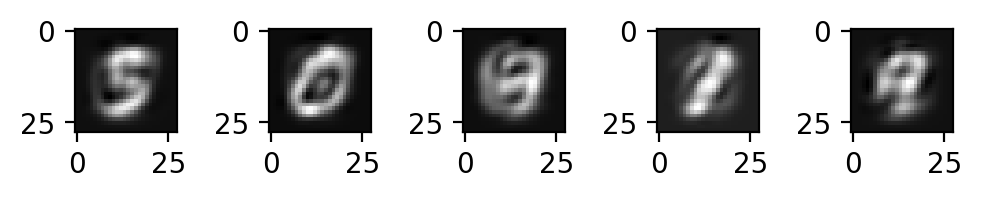

In [63]:
# Let's see what the images look like

NO_Images = 5
fig, axes = plt.subplots(1, NO_Images, figsize=(5, 1))

for i in range(NO_Images):
  axes[i].imshow(newImages20[i], cmap='gray')

plt.tight_layout()
plt.show()

In [64]:
# Lets check to see if the model still performs well on the test images
test_loss, test_acc = model.evaluate(train_images,  train_labels, verbose=2)
print('\nTest accuracy:', test_acc)

1875/1875 - 4s - 2ms/step - accuracy: 0.8935 - loss: 0.7705

Test accuracy: 0.8934500217437744


The model fails to achieve the 95% accuracy threshold which when you look at the images seems reasonable as they're quite unreadable.

In [65]:
# Test out how well the trained model works for image with 100 different PCA components
for i in range(len(PCA_Components)):
    newImages20 = (np.dot(P[:, 0:PCA_Components[i]], vecs.T[0:PCA_Components[i], :])) + mu
    newImages20 = np.reshape(newImages20, [60000, 28, 28])
    predictions = model.evaluate(newImages20, train_labels)
    accuracy_array[i] = predictions[1]

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1358 - loss: 6.6444
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6449 - loss: 1.3712
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9674 - loss: 0.1170
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9562 - loss: 0.1760
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9427 - loss: 0.2672
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9378 - loss: 0.2967
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9377 - loss: 0.2991


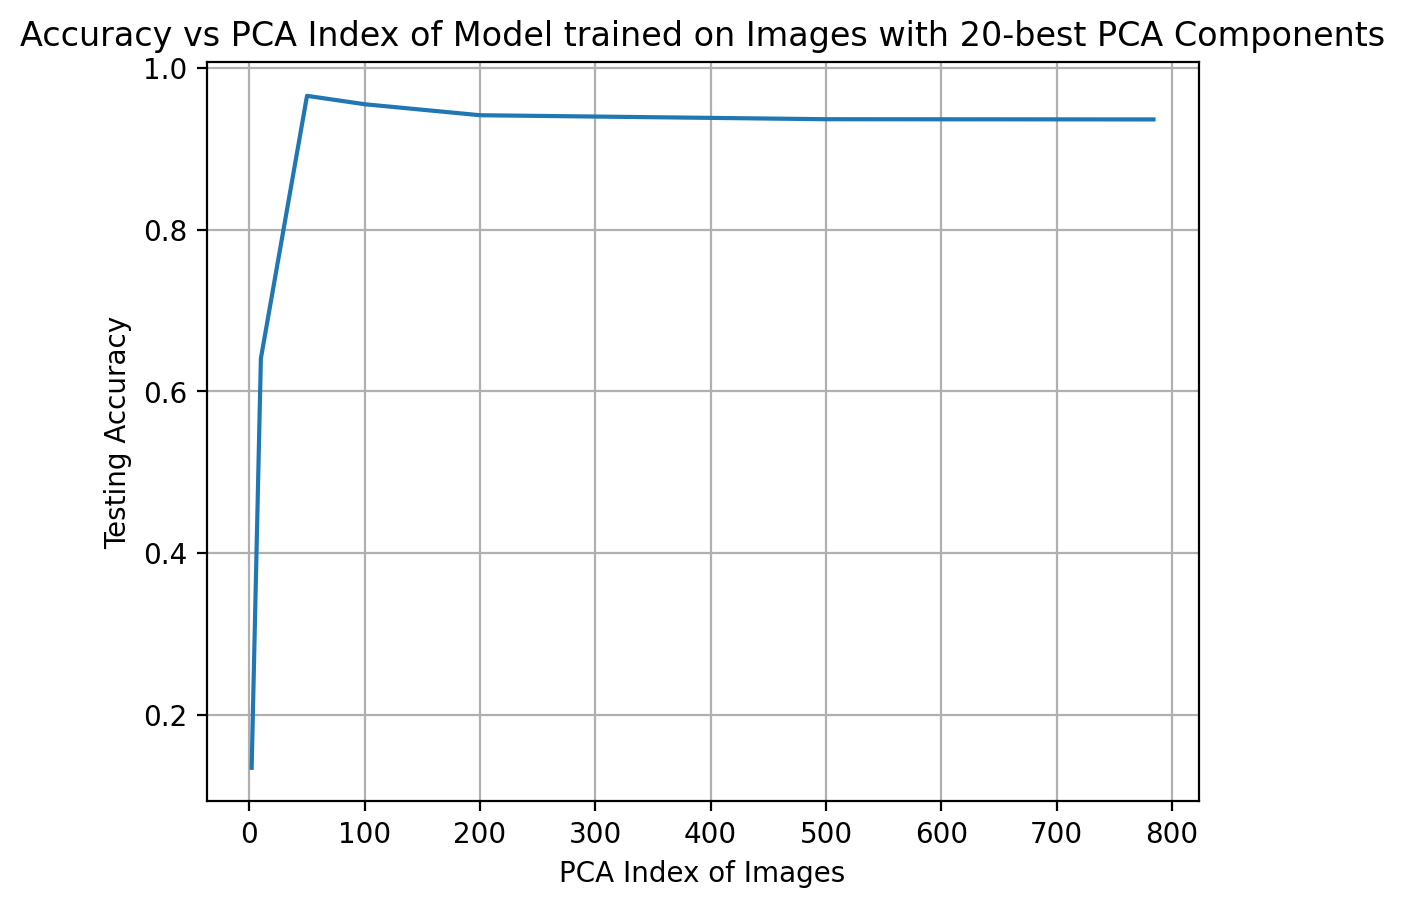

In [66]:
fig,ax=plt.subplots()
ax.plot(PCA_Components,accuracy_array)
ax.set_xlabel("PCA Index of Images")
ax.set_ylabel("Testing Accuracy")
ax.set_title("Accuracy vs PCA Index of Model trained on Images with 20-best PCA Components")
ax.grid()

The model peaks at around 50-best PCA components before dropping off and staying pretty much constant, similiar to the previous model trained on 100-best PCA components. The overall accuracy in general is worse which is expected as the model was trained on images which were less detailed.

Generally it's when you train a model, you don't want to train it with images that have all information/detail already, like how we did earlier, so that they can learn to identify images which are less clear/have some data loss. However, training with images that have too little detail make learning the images 'too hard', as we saw with the model trained on the 20-best PCA components. Hence it's upto the user themselves to decide what level of detail/data would be best for the model to learn the best from. This of course depends on the objectives of the user, they should train the model with images it would typically be expected to identify for deployment.